In [1]:
import numpy as np
import pandas as pd
import emcee
from scipy import stats
from scipy.optimize import curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dataloader import *

sns.set(style='ticks', context='talk')
plt.style.use("paper.mplstyle")

## Population Definition

### Bivariate Normal

In [2]:
size = 1000000
rho_xy = 0.25
sigma_x = 1
sigma_y = 1
cov_xy = rho_xy * (sigma_x * sigma_y)
cov = np.array([[sigma_x**2,    cov_xy], 
                [ cov_xy,   sigma_y**2]])
m = rho_xy * sigma_y / sigma_x
b = 0

population_dist = stats.multivariate_normal(cov=cov)
population_sample = population_dist.rvs(size)
x, y = population_sample[:, 0], population_sample[:, 1]
r_xy = stats.pearsonr(x, y)[0]
m_best =  r_xy * np.std(y) / np.std(x)
b_best =  np.mean(y) - m_best*np.mean(x)

print("Population Correlation:", r_xy)

Population Correlation: 0.24955648671784122


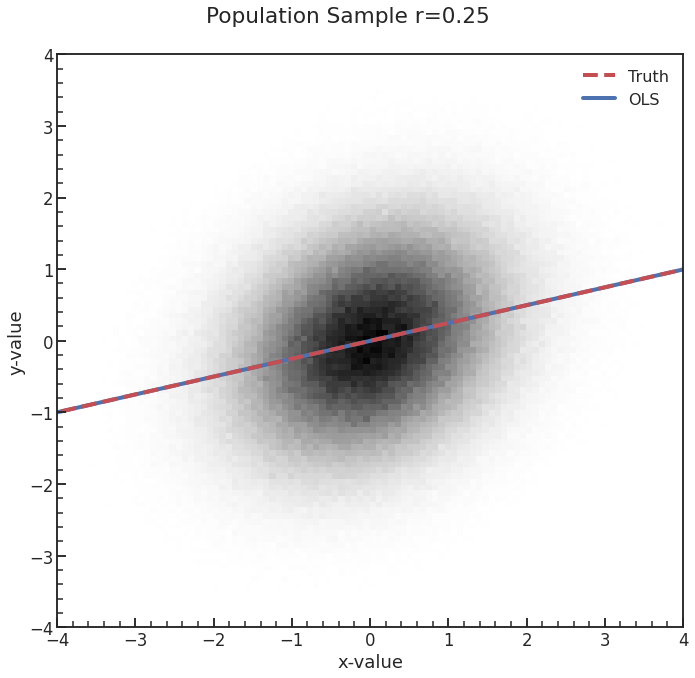

In [3]:
def f(x, m, b):
    return m*x + b

fig = plt.figure(figsize=(10, 10))
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-4, 4]], cmap="gray_r");

xrange = np.linspace(-6, 6, 100)
plt.plot(xrange, f(xrange, m_best, b_best), 'r--', label="Truth")


popt, _ = curve_fit(f, x, y)
plt.plot(xrange, f(xrange, *popt), label="OLS", zorder=1)

fig.suptitle("Population Sample r=0.25")
plt.xlabel("x-value")
plt.ylabel("y-value")
plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("figures/bivariate.png")

## Measurement Sample

Each measurement sample will be measured with error of constant variance. 

* The first sample will have equal variance on x and y error. 
* The second sample will have x error be 5 times greater than y error. 
* The third will have x error be 10 times greater than y error.

In [4]:
data_size = 100
data_idx = np.random.randint(0, size, size=data_size)

sigma_x = np.ones(data_size) * 0.2
sigma_y = np.ones(data_size) * 0.2
xerr = stats.norm(loc=0, scale=sigma_x).rvs(data_size)
yerr = stats.norm(loc=0, scale=sigma_y).rvs(data_size)

### Measurement Sample 1

Both x and y has single value errors with error ratio of 1.

,x,xerr,y,yerr
43,-2.908305,0.2,-1.444976,0.2
85,-1.999241,0.2,-1.053162,0.2
20,-1.990285,0.2,0.435741,0.2
24,-1.938817,0.2,-0.214268,0.2
73,-1.880695,0.2,0.241815,0.2


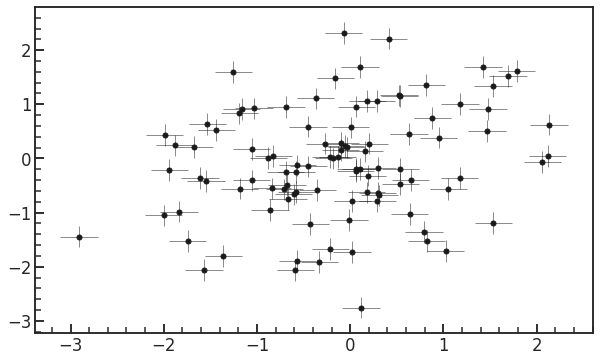

In [5]:
xdata = x[data_idx] + xerr*1
ydata = y[data_idx] + yerr*1

df1 = pd.DataFrame(
    {
        "x": xdata,
        "xerr": sigma_x,
        "y": ydata,
        "yerr": sigma_y,
    }
).sort_values('x')

plt.errorbar(df1.x, df1.y, yerr=df1.yerr, xerr=df1.xerr, c='k', fmt='ko', 
             lw=0.5, ms=5)
df1.head()

### Measurement Sample 2

Both x and y has single value errors with error ratio x of y being 5

,x,xerr,y,yerr
73,-2.961489,1.0,0.241815,0.2
85,-2.752533,1.0,-1.053162,0.2
20,-2.499780,1.0,0.435741,0.2
35,-2.382069,1.0,-2.066177,0.2
43,-2.350833,1.0,-1.444976,0.2


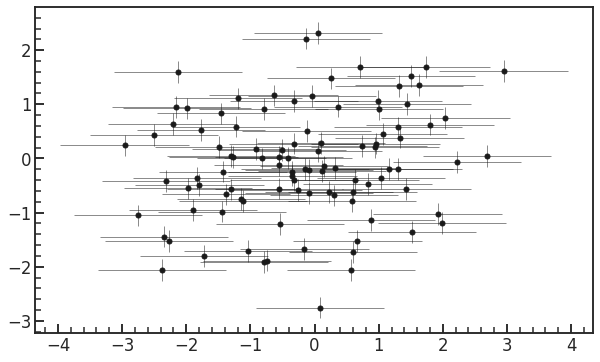

In [6]:
xdata = x[data_idx] + xerr*5
ydata = y[data_idx] + yerr

df2 = pd.DataFrame(
    {
        "x": xdata,
        "xerr": sigma_x*5,
        "y": ydata,
        "yerr": sigma_y,
    }
).sort_values('x')

plt.errorbar(df2.x, df2.y, yerr=df2.yerr, xerr=df2.xerr, fmt='ko', 
             lw=0.5, ms=5)
df2.head()

### Measurement Sample 3

Both x and y has errors of variance uniformly assigned. The error ratio is about 5

,x,xerr,y,yerr
73,-2.961489,1.0,0.241815,0.2
85,-2.752533,1.0,-1.053162,0.2
20,-2.499780,1.0,0.435741,0.2
35,-2.382069,1.0,-2.066177,0.2
43,-2.350833,1.0,-1.444976,0.2


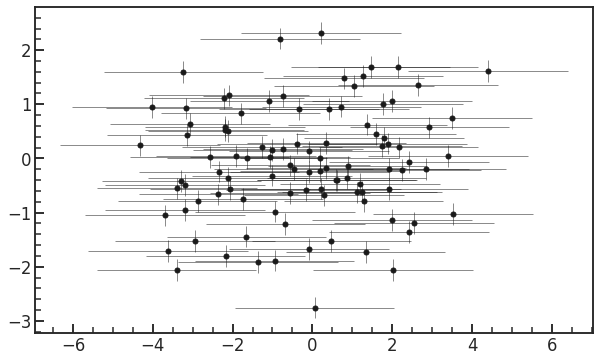

In [7]:
xdata = x[data_idx] + xerr*10
ydata = y[data_idx] + yerr

df3 = pd.DataFrame(
    {
        "x": xdata,
        "xerr": sigma_x*10,
        "y": ydata,
        "yerr": sigma_y,
    }
).sort_values('x')

plt.errorbar(df3.x, df3.y, yerr=df3.yerr, xerr=df3.xerr, fmt='ko', 
             lw=0.5, ms=5)
df2.head()

## Model

Let $Y^*$ and $X^*$ be the random variable with the population distribution and $Y$ and $X$ be the sample measured with error $\varepsilon_y \sim \text{Normal}(0, \sigma_x)$ and $\varepsilon_x \sim \text{Normal}(0, \sigma_y)$ respectively. We assume that $Y^*$ and $X^*$ are linearly related with the residual called the intrinsic scatter $\epsilon_\text{int} \sim \text{Normal}(0, \sigma_\text{int})$ where $\sigma_\text{int}$ is unknown and to be fitted for. 

**Theory**

$
Y^* = \theta_1 X^* + \theta_0 + \epsilon
$

**Measurement**

$
Y = Y^* + \varepsilon_y\\
X = X^* + \varepsilon_x\\
$

**Likelihood Function**

The probability to observe a given value from $Y$ conditioned on a value from $X$ and the model described above is

$
\begin{align}
P(Y=y \mid X=x, \epsilon_\text{int}=\epsilon; \theta) = P(Y=y; \theta)
\end{align}
$

$
\begin{align}
Y = \theta_1 X^* + \theta_0 + \epsilon + \varepsilon_y
\end{align}
$

### Different than LINMIX

LINMIX by [Kelly 2007](http://adsabs.harvard.edu/abs/2007ApJ...665.1489K) (hereon called Kelly07) differs from the model above by LINMIX having the addition assumption:

1. $X^*$ is assumed be distributed as Gaussian mixture model with $k$ components each component has the Gaussian mean parameter $\mu_i$ and variance parameter $\tau_i^2$,
    
    $
    \begin{align}
    X \sim \sum_{i=1}^k P_i \cdot (\tau_i Z_i + \mu_i)
    \end{align}
    $
    
    Where $Z_i$ for all $i$ are IID standard normal. $P_i$ for all $i$ are independently distributed as the $\text{Bernouli}(p_i)$.
    
    This assumption is a free parameter in MCMC and can be interpreted as an attempt to fit the X distribution as a Gaussian mixture model.

## Slope Posterior via LINMIX

In [9]:
from linmix import linmix

lm1 = linmix.LinMix(age_df['age'].groupby('snid').mean(), hr_df['hr'], xsig=0, ysig=hr_df['hr_err'],
    K=3, seed=912
)
lm1.run_mcmc(maxiter=5000)

lm1 = linmix.LinMix(age_df['age'].groupby('snid').mean(), hr_df['hr'], xsig=age_df['age'].groupby('snid').std(), ysig=hr_df['hr_err'],
    K=3, seed=912
)
lm1.run_mcmc(maxiter=5000)

NameError: name 'age_df' is not defined